# Dependency distribution in UD languages

Dependency relations are expected to have different distributions between languages. This purpose of this notebook is to give you a quick overlook of their distribution. 

Possibly critical decisions: 

- I ignore everything after the colon in the deprel label. That is, _nsubj:something_ counts as _nsubj_.
- I count relations between words, not between tokens. E.g, _haven't_ is separated as _have not_, with its new relation counted.

In [9]:
# Increase figure size
%matplotlib inline
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)

treebank_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1"

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import fileinput
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import join
from collections import defaultdict
from scipy.stats import entropy
from matplotlib import pylab

# Languages ordered according to their sTTR score (see other notebook for how).
sttr_order = ['UD_Finnish',
              'UD_Basque',
              'UD_Finnish-FTB',
              'UD_Hebrew',
              'UD_Czech',
              'UD_Indonesian',
              'UD_German',
              'UD_Hungarian',
              'UD_Greek',
              'UD_Croatian',
              'UD_Danish',
              'UD_Bulgarian',
              'UD_French',
              'UD_Spanish',
              'UD_Irish',
              'UD_Swedish',
              'UD_Italian',
              'UD_Persian',
              'UD_English']


# Extract treebank paths. Lists are necessary since Czech has multiple files.
train_files = {'UD_Basque': ['eu-ud-train.conllu'], 
              'UD_Croatian': ['hr-ud-train.conllu'], 
              'UD_Danish': ['da-ud-train.conllu'], 
              'UD_Finnish': ['fi-ud-train.conllu'], 
              'UD_French': ['fr-ud-train.conllu'], 
              'UD_Greek': ['el-ud-train.conllu'], 
              'UD_Hungarian': ['hu-ud-train.conllu'], 
              'UD_Irish': ['ga-ud-train.conllu'], 
              'UD_Persian': ['fa-ud-train.conllu'], 
              'UD_Swedish': ['sv-ud-train.conllu'], 
              'UD_Bulgarian': ['bg-ud-train.conllu'], 
              'UD_Czech': ['cs-ud-train-c.conllu',
                           'cs-ud-train-m.conllu',
                           'cs-ud-train-v.conllu',
                           'cs-ud-train-l.conllu'], 
              'UD_English': ['en-ud-train.conllu'], 
              'UD_Finnish-FTB': ['fi_ftb-ud-train.conllu'], 
              'UD_German': ['de-ud-train.conllu'], 
              'UD_Hebrew': ['he-ud-train.conllu'], 
              'UD_Indonesian': ['id-ud-train.conllu'], 
              'UD_Italian': ['it-ud-train.conllu'], 
              'UD_Spanish': ['es-ud-train.conllu']}

# UD_Language: [filepaths]
treebanks = {f: [join(treebank_path, f, train_file) for train_file in train_files[f]]
             for f in listdir(treebank_path) 
             if f.startswith("UD_")}  # remove hidden files

class Tree:
    def __init__(self, tree):
        self.raw = tree
        # Counts the dependency relations
        self.deprel_count = self._raw_to_deprel_count(tree)
    
    def _raw_to_deprel_count(self, tree):
        deprels = defaultdict(int)
        for line in tree:
            w_id = line.split()[0]
            # removing finegrained relations
            deprel = line.split()[7].split(":")[0]
            if "-" in w_id:
                continue
            
            deprels[deprel] += 1
            
        return deprels
    
def to_trees(f):
    tree = []
    for line in f:
        line = line.strip()
        if line.startswith("#"):
            continue
            
        if len(line) == 0:  # end of tree
            yield Tree(tree)
            tree.clear()
            continue

        tree.append(line)

def parse_conllu(conllu_path):
    # fileinput.input takes a list of files and treats them as one
    with fileinput.input(conllu_path) as f:  
        for tree in to_trees(f):
            yield tree
            
def sum_deprels(trees):
    deprels = defaultdict(int)
    for tree in trees:
        for rel, freq in tree.deprel_count.items():
            deprels[rel] += freq
    return deprels
        

In [6]:
df_dict = {}
for language, treebank in treebanks.items():
    deprels = sum_deprels(parse_conllu(treebank))
    df_dict[language] = deprels

deprel_per_lang = pd.DataFrame.from_dict(df_dict).transpose()

## Dependency distribution: Sorted by most common

Leftmost on the x-axis is the most commonly occurring relation (as in the sum of their ratio in each language) among all languages.

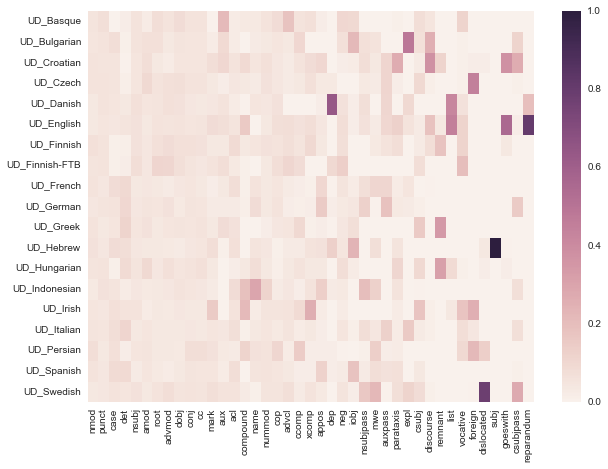

In [7]:
normalized = deprel_per_lang.div(deprel_per_lang.sum(axis=1), axis=0).fillna(0)
most_common_rels = normalized.sum(axis=0).sort_values(ascending=False)
normalized = normalized.div(normalized.sum(axis=0), axis=1)
sns.heatmap(normalized[most_common_rels.index])

# Sort languages by sTTR and relations by entropy

We will use the results in [Type-token ratio in Universal Dependencies treebanks](/notebooks/Type-token%20ratio%20in%20Universal%20Dependencies%20treebanks.ipynb) to sort the languages in an order that makes it easier to find discriminative dependency relations.

We also calculate the entropy of a dependency relation to find out its discriminative power. The lower the entropy, the stronger its discriminative power is. We sort the deprels according to this.

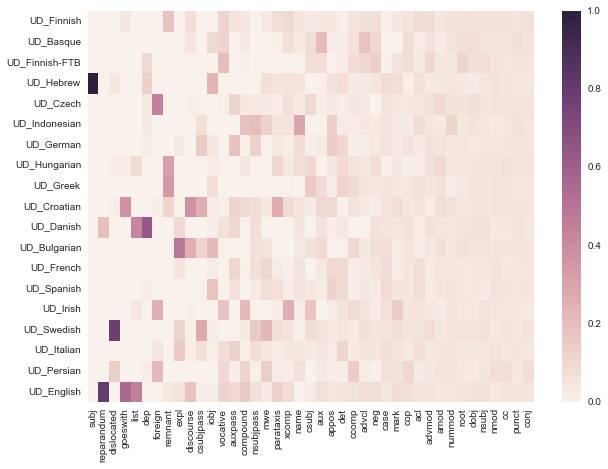

In [8]:
dep_entropies = pd.Series(entropy(normalized), normalized.columns).sort_values()
entropy_sorted = normalized[dep_entropies.index].ix[sttr_order].fillna(0)
entropy_normalized = entropy_sorted.div(entropy_sorted.sum(axis=0), axis=1)
sns.heatmap(entropy_normalized)

# Conclusion

First and foremost, we can say that the following are more or less equally distributed across all classes: conj, punct, cc, nmod, nsubj, dobj, root, nummod, amod, advmod, acl, cop, mark, case, neg, advcl.

I would like to say that we start to see some differences for these classes: ccomp, det, appos, aux, csubj, name, xcomp, parataxis, mwe, nsubjpass, ccompound, auxpass, vocative, iobj, csubjpass, discourse, expl, remnant, foreign, dep, list, goeswith, dislocated, reparandum (only present in Danish and English), subj (only present in Hebrew). 

It is not exactly clear that this will help us create the content and functional dependency classification. I will have to think about this a bit more.